<a href="https://colab.research.google.com/github/osvico/Proyectos-IA/blob/Redes-Convolucionales/Oscar_Vizcaino_Proyecto2%C2%AAEv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 2ªEV - Óscar Vizcaíno Córcoles

## Descarga de las imagenes:

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
download = drive.CreateFile({'id':'1GrgOPWPouxQ4cDWMWBypEhbmyMrpYgro'})
download.GetContentFile('frontal_lateral_train_validation.zip')

In [ ]:
with zipfile.ZipFile('frontal_lateral_train_validation.zip', 'r') as zip_ref:
 zip_ref.extractall('frontal_lateral')

## Preparacion de los datasets:

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Defino la funcion para escalar las intensidades de las imagenes.
def scaling_normalization(image, label):
  image = tf.cast(image/255., tf.float32)
  return image, label

#Defino la funcion para que genere distintos datasets en funcion de los parametros que se le pasan.
#Esta funcion genera los datasets para Entrenamiento y Validacion.
def get_data(tamanolote, tamanoimagen):
  train_dataset = image_dataset_from_directory(
  '/content/frontal_lateral/frontal_lateral_train_validation/train',
  color_mode='grayscale',
  seed=5,
  shuffle=True,
  batch_size=tamanolote,
  image_size=(tamanoimagen)
  )

  validation_dataset = image_dataset_from_directory(
  '/content/frontal_lateral/frontal_lateral_train_validation/validation',
  color_mode='grayscale',
  seed=5,
  shuffle=False,
  batch_size=tamanolote,
  image_size=(tamanoimagen)
  )

  #Escalado de las intensidades
  train_dataset = train_dataset.map(scaling_normalization)
  validation_dataset = validation_dataset.map(scaling_normalization)
  return train_dataset,validation_dataset

In [ ]:
train_dataset,validation_dataset = get_data(32,(256,256))

Found 600 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


### Muestra de 10 imagenes aleatorias, 5 de cada clase:

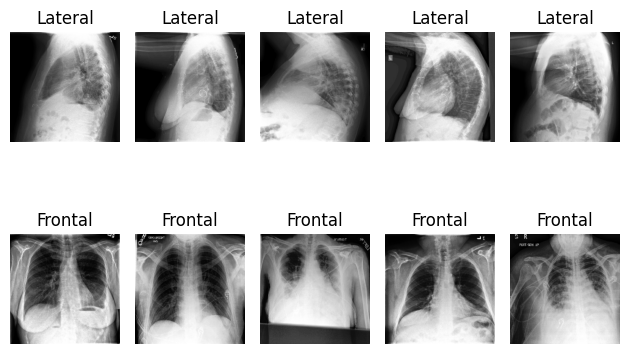

In [ ]:
plt.figure() 
imagenlabel0=0 #Inicializar contador para label=0
imagenlabel1=0 #Inicializar contador para label=1
posicionFigure=0 #Contador para la posicion en la figura de cada imagen.

#Adapto para que el metodo imshow() muestre imagenes en escala de grises (Por defecto muestra RGB)
for images, labels in train_dataset.take(1):
  for i in range(600):
    if imagenlabel0==5 and imagenlabel1==5:
      exit
    elif labels[i] == 0 and imagenlabel0<=4:
      axes = plt.subplot(2, 5, posicionFigure+1)
      dim=np.array(images)
      dim=images[:,:,:,0]
      plt.imshow(dim[i],cmap='gray')
      posicionFigure=posicionFigure+1
      imagenlabel0=imagenlabel0+1
      plt.title('Frontal')
      plt.axis("off")
    elif labels[i]==1 and imagenlabel1<=4:
      axes = plt.subplot(2, 5, posicionFigure+1)
      dim=np.array(images)
      dim=images[:,:,:,0]
      plt.imshow(dim[i],cmap='gray')
      posicionFigure=posicionFigure+1
      imagenlabel1=imagenlabel1+1
      plt.title('Lateral')
      plt.axis("off")
    else:
      pass
plt.tight_layout()

## Ejercicio 1: Implementar el modelo requerido:

In [ ]:
 #Añado esta libreria para poder calcular F1-score en funcion de las epocas durante el entrenamiento.
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from matplotlib import ticker,figure
from pathlib import Path
import random
import tensorflow_addons as tfa

### Generacion y entrenamiento del primer modelo

In [ ]:
def get_model():
  np.random.seed(15)
  tf.random.set_seed(15)
  random.seed(15)

  #Arquitectura convolucional:
  input_layer = layers.Input(shape=(256,256,1))
  layer_conv = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1),padding="same",activation="relu")(input_layer)
  layer_conv = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1),padding="same",activation="relu")(layer_conv)
  pool = layers.MaxPool2D(pool_size=(2, 2))(layer_conv)
  layer_conv = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1),padding="same",activation="relu")(pool)
  layer_conv = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1),padding="same",activation="relu")(layer_conv)
  pool = layers.MaxPool2D(pool_size=(2, 2))(layer_conv)
  layer_conv = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1),padding="same",activation="relu")(pool)
  layer_conv = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1),padding="same",activation="relu")(layer_conv)
  pool = layers.MaxPool2D(pool_size=(2, 2))(layer_conv)
  layer_conv = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1,1),padding="same",activation="relu")(pool)
  layer_conv = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1,1),padding="same",activation="relu")(layer_conv)
  global_avg = layers.GlobalAveragePooling2D()(layer_conv)

  dense_hidden = layers.Dense(32, activation='relu')(global_avg)
  dense_output = layers.Dense(1, activation='sigmoid')(dense_hidden)

  model = Model(inputs=[input_layer], outputs=[dense_output])
  return model

In [ ]:
model=get_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history=model.fit(train_dataset,
epochs=20,
batch_size=32,
validation_data=validation_dataset,
verbose=0)

### Grafica Loss entrenamiento y validacion del primer modelo

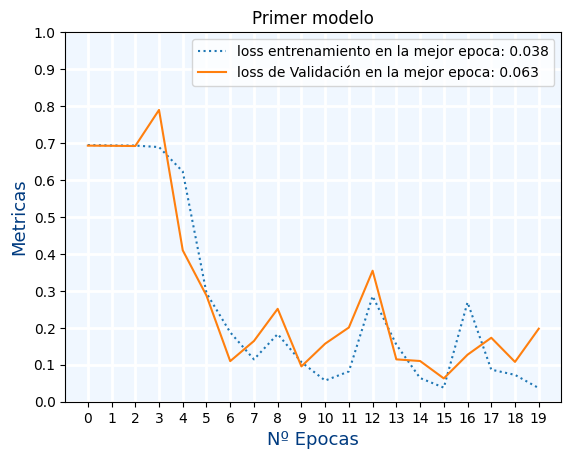

In [ ]:
figure=plt.figure()
axes = figure.add_subplot()
MejorEpoca=np.argmin(history.history['val_loss'][::-1])

axes.plot(history.history['loss'],linestyle="dotted",label="loss entrenamiento en la mejor epoca: " + str(round(history.history['loss'][-MejorEpoca-1],3)))
axes.plot(history.history['val_loss'],label="loss de Validación en la mejor epoca: " + str(round(history.history['val_loss'][-MejorEpoca-1],3)))

axes.set_xlabel('Nº Epocas', fontsize=13, color="#003B80")
axes.xaxis.set_major_locator(ticker.MaxNLocator(nbins=25,integer=True))

axes.set_ylabel('Metricas', fontsize=13, color="#003B80")
axes.set_ylim(ymin=0,ymax=1)
axes.yaxis.set_major_locator(ticker.MultipleLocator(0.1)) 

axes.set_title('Primer modelo')
axes.set_facecolor("#F0F7FF")
axes.grid(visible=True, which='major', axis='both', color="#FFFFFF", linewidth=2)

axes.legend()

## Ejercicio 2: Entrenamientos con distintos optimizadores y distintas tasas de aprendizaje

In [ ]:
optimizadores=(tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adam)
TasasAprendizaje=(0.001,0.006,0.0003)

In [ ]:
def plot_metrics(axes,history,title):
    axes = axes
    MejorEpoca=np.argmin(history.history['val_loss'][::-1])

    axes.plot(history.history['loss'],linestyle="dotted",label="loss entrenamiento en la mejor epoca: " + str(round(history.history['loss'][-MejorEpoca-1],3)))
    axes.plot(history.history['val_loss'],label="loss de Validación en la mejor epoca: " + str(round(history.history['val_loss'][-MejorEpoca-1],3)))

    axes.set_xlabel('Nº Epocas', fontsize=13, color="#003B80")
    axes.xaxis.set_major_locator(ticker.MaxNLocator(nbins=25,integer=True))

    axes.set_ylabel('Metricas', fontsize=13, color="#003B80")
    axes.set_ylim(ymin=0,ymax=1)
    axes.yaxis.set_major_locator(ticker.MultipleLocator(0.1)) 

    axes.set_title(title)
    axes.set_facecolor("#F0F7FF")
    axes.grid(visible=True, which='major', axis='both', color="#FFFFFF", linewidth=2)

    axes.legend()

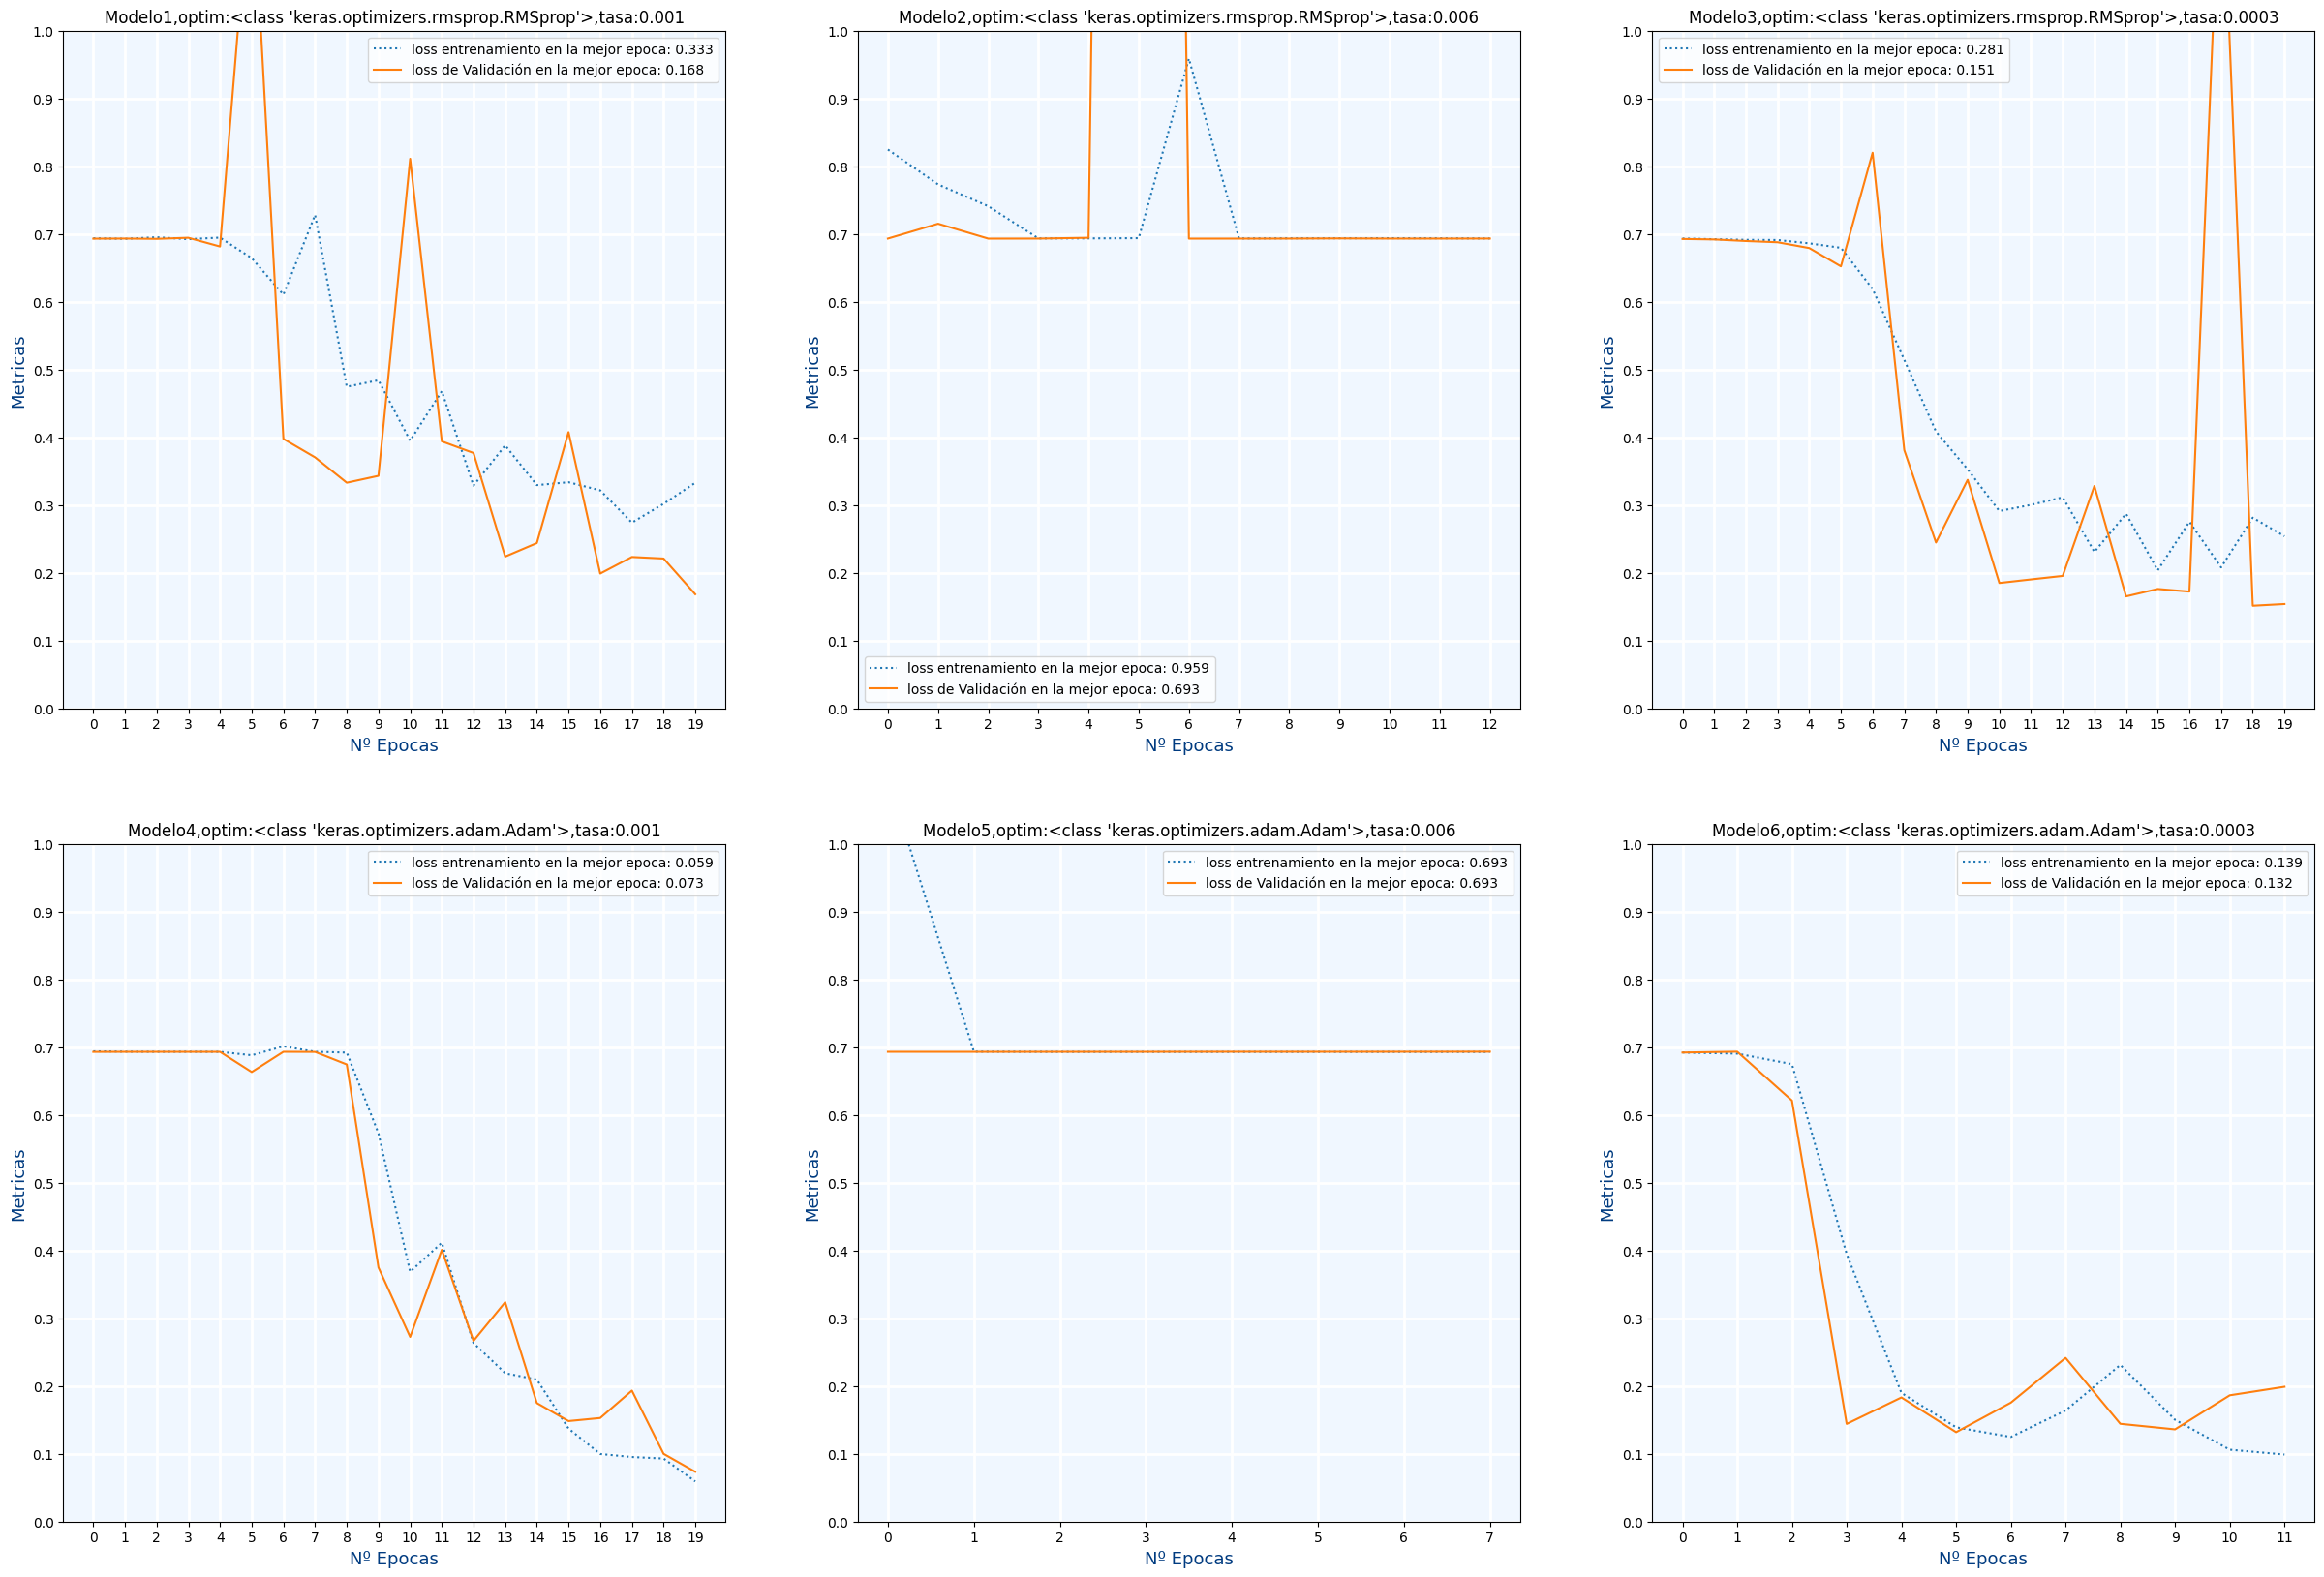

In [ ]:
#Variable contador que voy a utilizar tanto para posicionar las distintas graficas en la figura, 
#como para numerar los distintos modelos entre el 1 y el 6
NumModelo=1

figure=plt.figure(figsize=(30,20))

for optimizador in optimizadores:
  for tasa in TasasAprendizaje:
    model=get_model()
    optimiz = optimizador(learning_rate=tasa)
    model.compile(optimizer=optimiz, loss='binary_crossentropy', metrics=['accuracy', 'AUC', tfa.metrics.F1Score(num_classes=1, threshold=0.5)])


    # Creamos directorio donde almacenar resultados (models), las distintas redes se guardaran aqui.
    # Cada una se guarda en su priopio directorio con nombre: Modelo{1....6}
    path_models = Path('models')
    path_experiment = path_models / (f'Modelo{NumModelo}')
    path_experiment.mkdir(exist_ok=True, parents=True)

    #Generamos el callback y earlystoped.
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 mode="min", patience=6,
                                                 restore_best_weights=True,
                                                 verbose=0)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_experiment / 'xrai_frontal_lateral.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0)

    #Entrenamiento
    history=model.fit(train_dataset,
    epochs=20,
    batch_size=32,
    validation_data=validation_dataset,
    callbacks=[model_checkpoint_callback,earlystopping],
    verbose=0)
    
    #Guardado del archivo history.npy con las metricas de cada modelo
    np.save(path_experiment / 'history.npy', history.history)

    #Añadir grafico del modelo
    axes = figure.add_subplot(2,3,NumModelo)
    plot_metrics(axes,history,(f'Modelo{NumModelo},optim:{optimizador},tasa:{tasa}'))
    NumModelo +=1

plt.show()

## Ejercicio 3: Elegir y justificar los dos mejores modelos del ejercicio 2

Los modelos seleccionados, los modelos 4 y 6 pertenecinetes los dos al optimizador 'ADAM' con una tasa de aprendizaje de 0,001 y 0,0003 respectivamente. Pasan a llamarte modelo A y modelo B. Escojo estos en primer lugar por los resultados de la perdida en validación, pero a de mas son los dos modelos mas estables y convergentes en la mejor de sus epocas.

### Graficas de F1-Score y AUC-ROC

#### Carga y extracción de datos de las metricas a utilizar

Extraigo los datos de F1-Score y AUC-ROC del archivo history.npy de los dos modelos seleccionados

In [ ]:
history_model_A=np.load('/content/models/Modelo4/history.npy',allow_pickle=True)
history_model_B=np.load('/content/models/Modelo6/history.npy',allow_pickle=True)

In [ ]:
#Extraigo las metricas F1-Score y AUC del history de mis mejores modelos (4 y 6)

#Metricas Modelo A
f1_A=history_model_A.tolist()['f1_score']
val_f1_A=history_model_A.tolist()['val_f1_score']
auc_A=history_model_A.tolist()['auc']
val_auc_A=history_model_A.tolist()['val_auc']

#Metricas Modelo B
f1_B=history_model_B.tolist()['f1_score']
val_f1_B=history_model_B.tolist()['val_f1_score']
auc_B=history_model_B.tolist()['auc']
val_auc_B=history_model_B.tolist()['val_auc']

#### AUC_ROC y F1-Score Modelo A

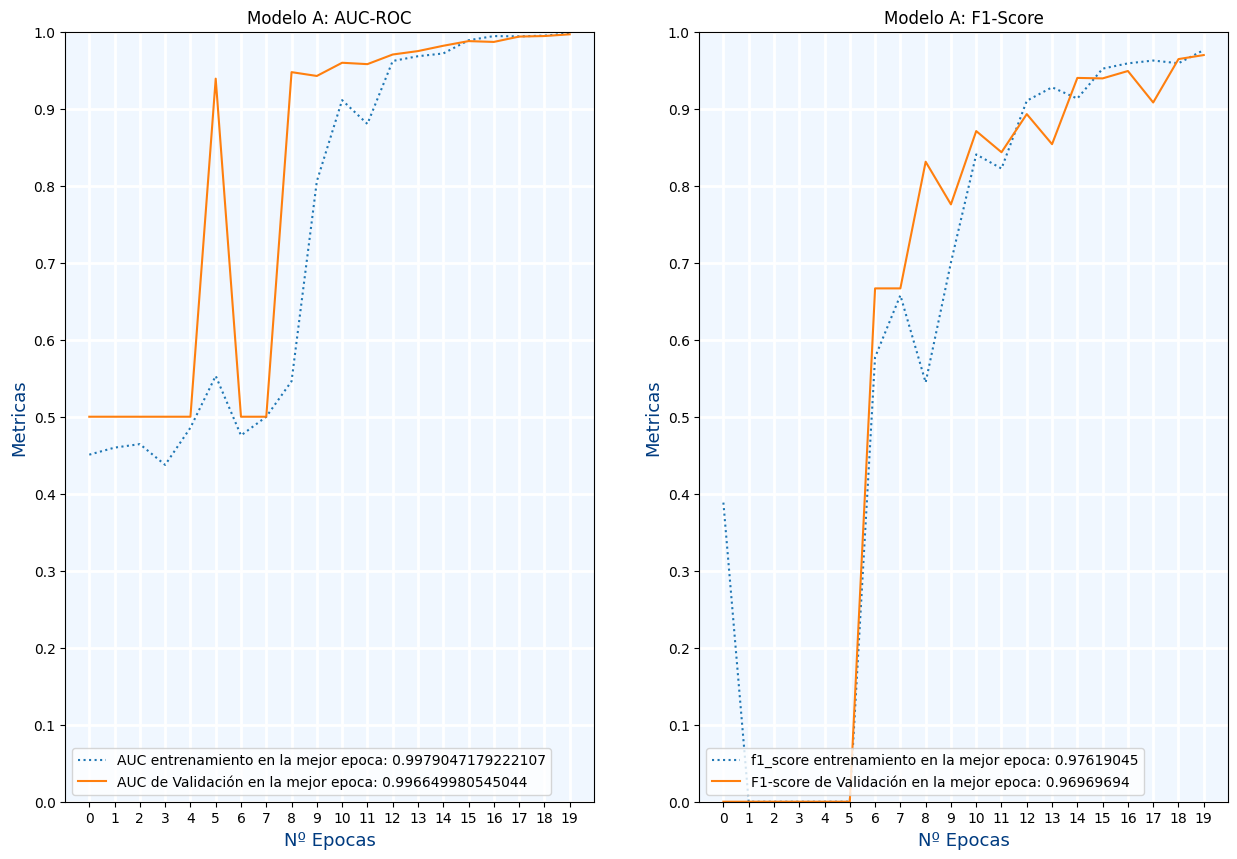

In [ ]:
figure=plt.figure(figsize=(15,10))
axes = figure.add_subplot(1,2,1)
axes1 = figure.add_subplot(1,2,2)

axes.plot(auc_A,linestyle="dotted",label="AUC entrenamiento en la mejor epoca: " + str(auc_A[-1]))
axes.plot(val_auc_A,label="AUC de Validación en la mejor epoca: " + str(val_auc_A[-1]))

axes1.plot(f1_A,linestyle="dotted",label="f1_score entrenamiento en la mejor epoca: " + str(f1_A[-1][0]))
axes1.plot(val_f1_A,label="F1-score de Validación en la mejor epoca: " + str(val_f1_A[-1][0]))

axes.set_xlabel('Nº Epocas', fontsize=13, color="#003B80")
axes.xaxis.set_major_locator(ticker.MaxNLocator(nbins=25,integer=True))

axes1.set_xlabel('Nº Epocas', fontsize=13, color="#003B80")
axes1.xaxis.set_major_locator(ticker.MaxNLocator(nbins=25,integer=True))

axes.set_ylabel('Metricas', fontsize=13, color="#003B80")
axes.set_ylim(ymin=0,ymax=1)
axes.yaxis.set_major_locator(ticker.MultipleLocator(0.1)) 

axes1.set_ylabel('Metricas', fontsize=13, color="#003B80")
axes1.set_ylim(ymin=0,ymax=1)
axes1.yaxis.set_major_locator(ticker.MultipleLocator(0.1)) 

axes.set_title('Modelo A: AUC-ROC')
axes.set_facecolor("#F0F7FF")
axes.grid(visible=True, which='major', axis='both', color="#FFFFFF", linewidth=2)

axes1.set_title('Modelo A: F1-Score')
axes1.set_facecolor("#F0F7FF")
axes1.grid(visible=True, which='major', axis='both', color="#FFFFFF", linewidth=2)

axes.legend()
axes1.legend()

#### AUC_ROC y F1-Score Modelo B

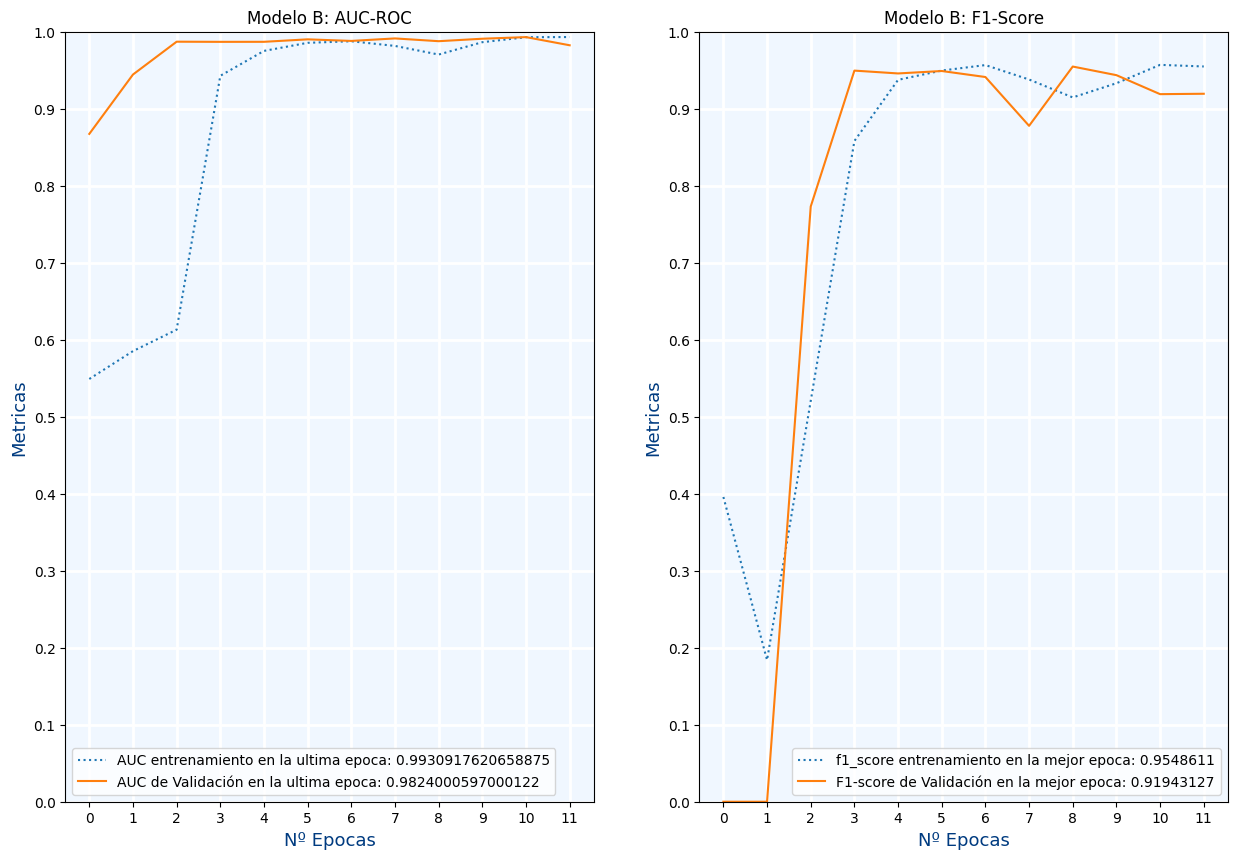

In [ ]:
figure=plt.figure(figsize=(15,10))
axes = figure.add_subplot(1,2,1)
axes1 = figure.add_subplot(1,2,2)

axes.plot(auc_B,linestyle="dotted",label="AUC entrenamiento en la ultima epoca: " + str(auc_B[-1]))
axes.plot(val_auc_B,label="AUC de Validación en la ultima epoca: " + str(val_auc_B[-1]))

axes1.plot(f1_B,linestyle="dotted",label="f1_score entrenamiento en la mejor epoca: " + str(f1_B[-1][0]))
axes1.plot(val_f1_B,label="F1-score de Validación en la mejor epoca: " + str(val_f1_B[-1][0]))

axes.set_xlabel('Nº Epocas', fontsize=13, color="#003B80")
axes.xaxis.set_major_locator(ticker.MaxNLocator(nbins=25,integer=True))

axes1.set_xlabel('Nº Epocas', fontsize=13, color="#003B80")
axes1.xaxis.set_major_locator(ticker.MaxNLocator(nbins=25,integer=True))

axes.set_ylabel('Metricas', fontsize=13, color="#003B80")
axes.set_ylim(ymin=0,ymax=1)
axes.yaxis.set_major_locator(ticker.MultipleLocator(0.1)) 

axes1.set_ylabel('Metricas', fontsize=13, color="#003B80")
axes1.set_ylim(ymin=0,ymax=1)
axes1.yaxis.set_major_locator(ticker.MultipleLocator(0.1)) 

axes.set_title('Modelo B: AUC-ROC')
axes.set_facecolor("#F0F7FF")
axes.grid(visible=True, which='major', axis='both', color="#FFFFFF", linewidth=2)

axes1.set_title('Modelo B: F1-Score')
axes1.set_facecolor("#F0F7FF")
axes1.grid(visible=True, which='major', axis='both', color="#FFFFFF", linewidth=2)

axes.legend()
axes1.legend()

### Matrices de confusion

##### Extrayendo y_true

Para crear las matrices de confusion, en primer lugar extraigo y_true de mi dataset de validación

In [ ]:
def get_labels(dataset):
    y_true = []
    for _, labels in dataset:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    return y_true

In [ ]:
y_true=get_labels(validation_dataset)

#### Matriz de consfusion del modelo A

Extrayendo la y predicha por del modelo A con los datos de validación y redondeando entre 0 y 1.

In [ ]:
# Cargar el modelo entrenado A
model = tf.keras.models.load_model('/content/models/Modelo4/xrai_frontal_lateral.h5')

# Obtener las etiquetas predichas (y_pred_A)
y_pred_A = []
for images, _ in validation_dataset:
    predictions = model.predict(images)
    labels = (predictions >= 0.5).astype(int)
    y_pred_A.extend(labels.flatten())

y_pred_A = np.array(y_pred_A)

1/1 [==============================] - 0s 111ms/step


##### Matriz de confusion A

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

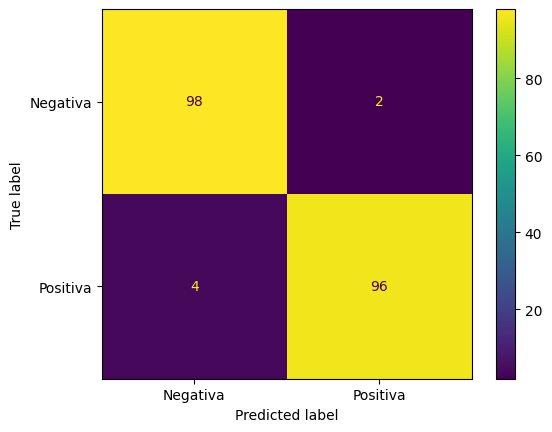

In [ ]:
cmA=confusion_matrix(y_true,y_pred_A)
cm=ConfusionMatrixDisplay(confusion_matrix=cmA,display_labels=['Negativa','Positiva'])
cm.plot()

#### Matriz de consfusion del modelo B

Extrayendo la y predicha por del modelo B con los datos de validación y redondeando entre 0 y 1.

In [ ]:
# Cargar el modelo entrenado A
model = tf.keras.models.load_model('/content/models/Modelo6/xrai_frontal_lateral.h5')

# Obtener las etiquetas predichas (y_pred_B)
y_pred_B = []
for images, _ in validation_dataset:
    predictions = model.predict(images)
    labels = (predictions >= 0.5).astype(int)
    y_pred_B.extend(labels.flatten())

y_pred_B = np.array(y_pred_B)

1/1 [==============================] - 0s 121ms/step


##### Matriz de confusión B

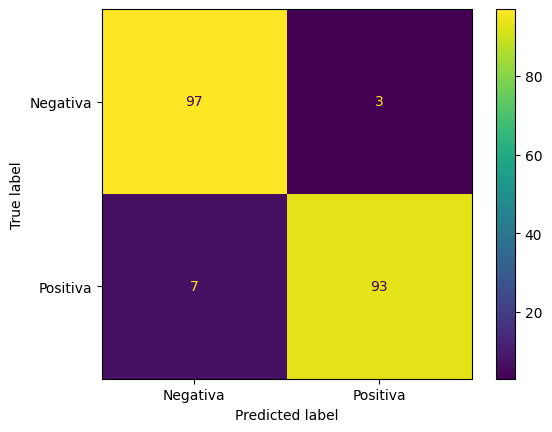

In [ ]:
cmB=confusion_matrix(y_true,y_pred_B)
cm=ConfusionMatrixDisplay(confusion_matrix=cmB,display_labels=['Negativa','Positiva'])
cm.plot()

## Ejercicio 4: Comparando los dos modelos (A y B)

Defino la funcion que utilizare para extraer las distintas metricas de cada uno de mis modelos.

In [ ]:
from sklearn.metrics import roc_auc_score
from math import sqrt

def calcular_metricas(y_true, y_pred):
    VP = sum((y_true == 1) & (y_pred >= 0.5))
    VN = sum((y_true == 0) & (y_pred < 0.5))
    FP = sum((y_true == 0) & (y_pred >= 0.5))
    FN = sum((y_true == 1) & (y_pred < 0.5))

    Accuracy = (VP + VN) / (VP + VN + FP + FN)
    Precision = VP / (VP + FP)
    Recall = VP / (VP + FN)
    NPV = VN / (VN + FN)
    Specificity = VN / (VN + FP)
    F1 = 2 * (Precision * Recall) / (Precision + Recall)
    MCC = (VP * VN - FP * FN) / sqrt((VP + FP) * (VP + FN) * (VN + FP) * (VN + FN))
    AUC = roc_auc_score(y_true, y_pred)
    
    return [VP, VN, FP, FN, Accuracy, Precision, Recall, NPV, Specificity, F1, MCC, AUC]

### Tabla comparativa de los Modelos A y B:

In [ ]:
import pandas as pd

metricas_A = calcular_metricas(y_true, y_pred_A)
metricas_B = calcular_metricas(y_true, y_pred_B)

# Crear el DataFrame con las métricas
data = {'Métrica': ['VP', 'VN', 'FP', 'FN', 'Accuracy', 'Precision', 'Recall', 'NPV', 'Specificity', 'F1', 'MCC', 'AUC'],
        'Modelo A': metricas_A,
        'Modelo B': metricas_B}

df = pd.DataFrame(data)

# Formatear las métricas VP, VN, FP, FN sin decimales
df[['Modelo A', 'Modelo B']] = df[['Modelo A', 'Modelo B']].applymap(lambda x: f'{x:.0f}' if isinstance(x, float) and x.is_integer() else x)

# Calcular la mejor métrica y agregarla al DataFrame
df['Mejor Modelo'] = df[['Modelo A', 'Modelo B']].apply(lambda row: 'A' if float(row['Modelo A']) > float(row['Modelo B']) else 'B', axis=1)
df.head(50)


,Métrica,Modelo A,Modelo B,Mejor Modelo
0,VP,96,93,A
1,VN,98,97,A
2,FP,2,3,B
3,FN,4,7,B
4,Accuracy,0.97,0.95,A
5,Precision,0.979592,0.96875,A
6,Recall,0.96,0.93,A
7,NPV,0.960784,0.932692,A
8,Specificity,0.98,0.97,A
9,F1,0.969697,0.94898,A


Después de observar las gráficas de la pérdida y considerar el resto de las métricas, se concluye que el Modelo A es la mejor opción. El Modelo A, que ahora será referido como Modelo C, aporta una pérdida en validación de 0.073, lo cual indica una buena capacidad de generalización y ajuste a los datos de validación.

Además, al analizar las métricas individuales, el Modelo C (anterior A) muestra un rendimiento superior en comparación con el Modelo B en todas las métricas evaluadas. Por ejemplo, tiene una mayor precisión (0.979592 frente a 0.96875), un mayor recall (0.96 frente a 0.93) y un mayor F1-score (0.969697 frente a 0.94898). Esto demuestra que el Modelo C tiene una mejor capacidad para clasificar correctamente las muestras positivas y negativas.

Además, el Modelo C tiene un valor de MCC (Coeficiente de Correlación de Matthews) más alto (0.940188 frente a 0.900721), lo cual indica una mejor capacidad para capturar las relaciones entre las predicciones y las clases reales.

En conclusion, el Modelo C, que era el Modelo A originalmente, es el que selecciono como mi mejor modelo.

## Ejercicio 5: Modelo de MobileNetV2 con transferencia de conocimiento

### Creo mis datasets en RGB

Como MobilenetV2 esta pensado para trabajar en imagenes RGB (3 canales), vuelvo a generar mis datasets pero en RGB

In [ ]:
train_dataset_rgb = image_dataset_from_directory(
'/content/frontal_lateral/frontal_lateral_train_validation/train',
seed=5,
shuffle=True,
batch_size=32,
image_size=(224,224))

validation_dataset_rgb = image_dataset_from_directory(
'/content/frontal_lateral/frontal_lateral_train_validation/validation',
seed=5,
shuffle=False,
batch_size=32,
image_size=(224,224))

Found 600 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


Vuelvo a mostrar 10 imagenes aleatorias de mi dataset de entrenamiento.

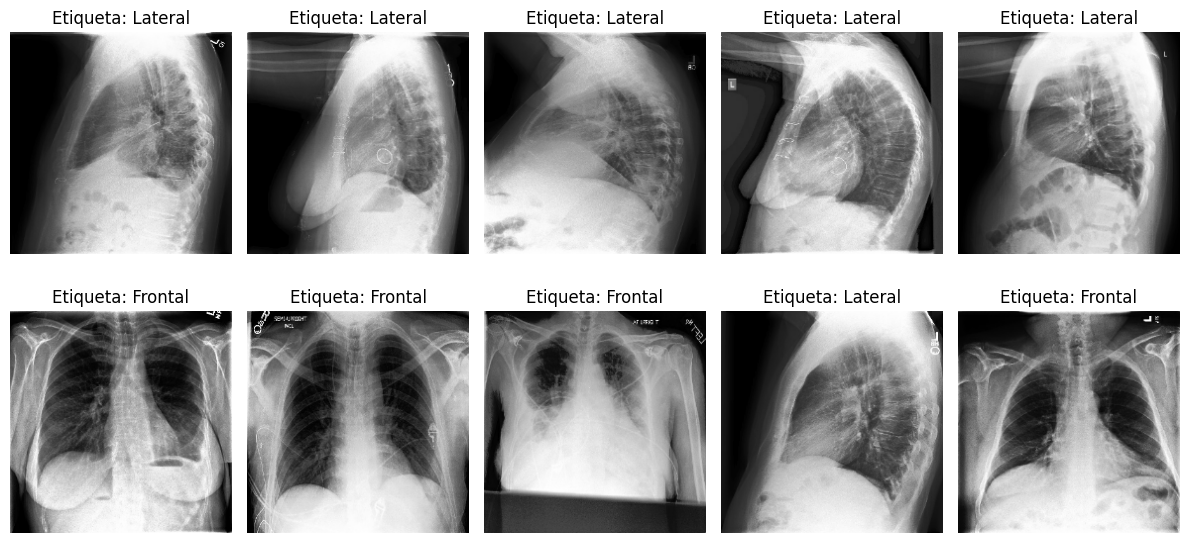

In [ ]:
import matplotlib.pyplot as plt

# Obtener un lote de 10 imágenes y etiquetas
images, labels = next(iter(train_dataset_rgb.take(1)))

# Mostrar las 10 imágenes en una misma figura
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axs.flat):
    ax.imshow(images[i].numpy().astype("uint8"))
    ax.set_title(f"Etiqueta: {'Frontal' if labels[i] == 0 else 'Lateral'}")
    ax.axis("off")

plt.tight_layout()
plt.show()

### Carga del modelo y extración de caracteristicas: MobileNetV2

In [ ]:
IMG_SHAPE = (224,224)+(3,) #Se descarga el modelo para un tamaño de imagen de 224,224 en RGB (3 canales)

model_mobilenetv2 = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
model_mobilenetv2.trainable = False
preprocess_input=tf.keras.applications.mobilenet_v3.preprocess_input

model_mobilenetv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_30[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
#Guardo el total de layers en la arquitectura original para el paso posterior de ajuste fino.
TotalLayers=len(model_mobilenetv2.layers)
print(TotalLayers)

154


In [ ]:
input = layers.Input(shape=(224, 224, 3))
# Capa preprocesado
x = preprocess_input(input)
# Añadimos modelo base
x = model_mobilenetv2(x, training=False)
global_avg = layers.GlobalAveragePooling2D()(x)
# Clasificación binaria
dense_hidden = layers.Dense(50, activation='relu')(global_avg)
dense_hidden = layers.Dense(32, activation='relu')(global_avg)
dense_output = layers.Dense(1, activation='sigmoid')(dense_hidden)
Modelo_MobileNetV2 = Model(inputs=[input], outputs=[dense_output])
Modelo_MobileNetV2.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_23  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_47 (Dense)            (None, 32)                40992     
                                                                 
 dense_48 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,299,009
Trainable params: 41,025
Non-train

### Entrenamiento extraccion de caracteristicas

In [ ]:
Modelo_MobileNetV2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# El resultado se guarda en la carpeta ModeloMobileNetV2 dentro del directorio Models
path_models = Path('models')
path_experiment = path_models / (f'ModeloMobileNetV2')
path_experiment.mkdir(exist_ok=True, parents=True)

#Generamos el callback y earlystoped.
earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 mode="min", patience=5,
                                                 restore_best_weights=True,
                                                 verbose=0)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=path_experiment / 'xrai_frontal_lateral_mobilenet.h5',
monitor='val_loss',
mode='min',
save_best_only=True,
verbose=0)

#Entrenamiento
history=Modelo_MobileNetV2.fit(train_dataset_rgb,
epochs=10,
batch_size=32,
validation_data=validation_dataset_rgb,
callbacks=[model_checkpoint_callback,earlystopping],
verbose=1)
    
#Guardado del archivo history.npy con las metricas de cada modelo
np.save(path_experiment / 'history.npy', history.history)

Epoch 1/10
19/19 [==============================] - 8s 197ms/step - loss: 0.2840 - accuracy: 0.8950 - val_loss: 0.1313 - val_accuracy: 0.9700
Epoch 2/10
19/19 [==============================] - 3s 104ms/step - loss: 0.0784 - accuracy: 0.9900 - val_loss: 0.0914 - val_accuracy: 0.9850
Epoch 3/10
19/19 [==============================] - 2s 87ms/step - loss: 0.0478 - accuracy: 0.9917 - val_loss: 0.0766 - val_accuracy: 0.9850
Epoch 4/10
19/19 [==============================] - 2s 87ms/step - loss: 0.0330 - accuracy: 0.9983 - val_loss: 0.0726 - val_accuracy: 0.9850
Epoch 5/10
19/19 [==============================] - 2s 87ms/step - loss: 0.0241 - accuracy: 0.9983 - val_loss: 0.0649 - val_accuracy: 0.9850
Epoch 6/10
19/19 [==============================] - 2s 88ms/step - loss: 0.0202 - accuracy: 0.9983 - val_loss: 0.0619 - val_accuracy: 0.9850
Epoch 7/10
19/19 [==============================] - 2s 111ms/step - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.0578 - val_accuracy: 0.9850
Epoch 8/10

### Ajuste Fino

In [ ]:
Modelo_MobileNetV2.training=True

#Descongelo el modelo y congelo unicamente la mitad. El num total se guarda en pasos anteriores (Variable TotalLayers)
for layer in Modelo_MobileNetV2.layers[:int(TotalLayers/2)]: 
  layer.trainable = False

In [ ]:
#Uso una tasa de aprendizaje pequeña durante el ajuste fino para evitar el sobreajuste.
Modelo_MobileNetV2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

#Entrenamiento
history_fine=Modelo_MobileNetV2.fit(train_dataset_rgb,
epochs=10,
batch_size=32,
validation_data=validation_dataset_rgb,
callbacks=[model_checkpoint_callback,earlystopping], #Reutilizo los callbacks
verbose=1)
    
#Guardado del archivo history.npy con las metricas de cada modelo
np.save(path_experiment / 'history.npy', history_fine.history)

Epoch 1/10
19/19 [==============================] - 6s 123ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0627 - val_accuracy: 0.9900
Epoch 2/10
19/19 [==============================] - 2s 69ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0627 - val_accuracy: 0.9900
Epoch 3/10
19/19 [==============================] - 2s 84ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0627 - val_accuracy: 0.9900
Epoch 4/10
19/19 [==============================] - 2s 90ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0627 - val_accuracy: 0.9900
Epoch 5/10
19/19 [==============================] - 2s 68ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0627 - val_accuracy: 0.9900
Epoch 6/10
19/19 [==============================] - 2s 73ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0627 - val_accuracy: 0.9900


In [ ]:
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

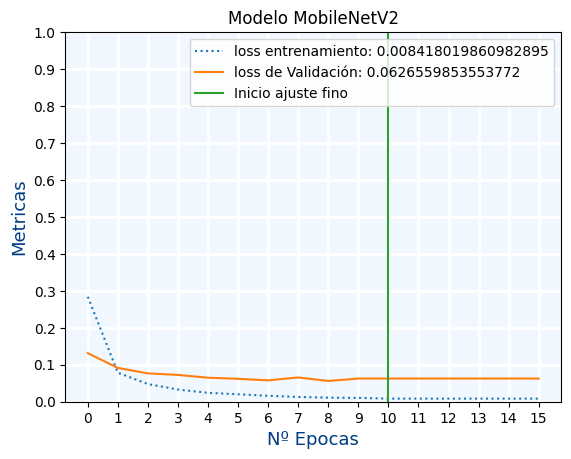

In [ ]:
figure=plt.figure()
axes = figure.add_subplot()

axes.plot(loss,linestyle="dotted",label="loss entrenamiento: " + str(loss[-1]))
axes.plot(val_loss,label="loss de Validación: " + str(val_loss[-1]))

axes.set_xlabel('Nº Epocas', fontsize=13, color="#003B80")
axes.xaxis.set_major_locator(ticker.MaxNLocator(nbins=25,integer=True))

axes.set_ylabel('Metricas', fontsize=13, color="#003B80")
axes.set_ylim(ymin=0,ymax=1)
axes.yaxis.set_major_locator(ticker.MultipleLocator(0.1)) 

axes.set_title('Modelo MobileNetV2')
axes.set_facecolor("#F0F7FF")
axes.grid(visible=True, which='major', axis='both', color="#FFFFFF", linewidth=2)

plt.ylim([0, 1])
plt.plot([10,10],
plt.ylim(), label='Inicio ajuste fino')

plt.legend()

## Ejercicio 6: Comparación del modelo C con modelo MobileNetV2

In [ ]:
# Cargar el modelo entrenado MobileNetV2
model = tf.keras.models.load_model('/content/models/ModeloMobileNetV2/xrai_frontal_lateral_mobilenet.h5')

# Obtener las etiquetas predichas (y_pred_mobilenet)
y_pred_mobilenet = []
for images, _ in validation_dataset_rgb:
    predictions = model.predict(images)
    labels = (predictions >= 0.5).astype(int)
    y_pred_mobilenet.extend(labels.flatten())

y_pred_mobilenet = np.array(y_pred_mobilenet)

1/1 [==============================] - 1s 821ms/step


In [ ]:
metricas_C = calcular_metricas(y_true, y_pred_A)
metricas_mobilenetV2 = calcular_metricas(y_true, y_pred_mobilenet)

# Crear el DataFrame con las métricas
data = {'Métrica': ['VP', 'VN', 'FP', 'FN', 'Accuracy', 'Precision', 'Recall', 'NPV', 'Specificity', 'F1', 'MCC', 'AUC'],
        'Modelo C': metricas_C,
        'Modelo MobileNetV2': metricas_mobilenetV2}

df = pd.DataFrame(data)

# Formatear las métricas VP, VN, FP, FN sin decimales
df[['Modelo C', 'Modelo MobileNetV2']] = df[['Modelo C', 'Modelo MobileNetV2']].applymap(lambda x: f'{x:.0f}' if isinstance(x, float) and x.is_integer() else x)

# Calcular la mejor métrica y agregarla al DataFrame
df['Mejor Modelo'] = df[['Modelo C', 'Modelo MobileNetV2']].apply(lambda row: 'C' if float(row['Modelo C']) > float(row['Modelo MobileNetV2']) else 'MobileNetV2', axis=1)
df.head(50)

,Métrica,Modelo C,Modelo MobileNetV2,Mejor Modelo
0,VP,96,100,MobileNetV2
1,VN,98,98,MobileNetV2
2,FP,2,2,MobileNetV2
3,FN,4,0,C
4,Accuracy,0.97,0.99,MobileNetV2
5,Precision,0.979592,0.980392,MobileNetV2
6,Recall,0.96,1,MobileNetV2
7,NPV,0.960784,1,MobileNetV2
8,Specificity,0.98,0.98,MobileNetV2
9,F1,0.969697,0.990099,MobileNetV2


Examinando en detalle las métricas y comparando el Modelo C con el Modelo MobileNetV2, se puede concluir que el Modelo MobileNetV2 se destaca como la mejor opcion. Aunque el Modelo C mostró un buen rendimiento en términos de pérdida en validación, el Modelo MobileNetV2 supera en gran medida al Modelo C en todas las métricas evaluadas. Con una pérdida en validación más baja y un rendimiento superior en precisión, recall, F1-score y el coeficiente de correlación de Matthews (MCC), el Modelo MobileNetV2 se posiciona como el mejor modelo. Su capacidad de generalización y su mayor exactitud en la clasificación hacen que sea la elección más acertada en esta comparativa.

## Ejercicio 7: Entrenamiento del Modelo C con aumento de datos

### Creación de los datasets con aumento de datos

In [ ]:
!pip install -q -U albumentations
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor
!pip install keras_preprocessing

In [ ]:
import albumentations as A
from ImageDataAugmentor.image_data_augmentor import *

In [ ]:
# Implementamos la rutina de transformaciones
transforms = A.Compose([
                        A.Rotate(limit=10, p=0.3),
                        A.RandomBrightnessContrast(p=0.5),
                        A.HorizontalFlip(p=0.1),
                        A.CLAHE(p=0.2)
                        ])

In [ ]:
# Generador de datos de entrenamiento
train_datagen = ImageDataAugmentor(
    augment=transforms,
    validation_split=0.0,
    seed=123)
# Generador de datos de validación
val_datagen = ImageDataAugmentor(seed=123,
                                 validation_split=0.0,
                                 augment=None)

In [ ]:
# Dataset de entrenamiento
train_dataset = train_datagen.flow_from_directory(
        '/content/frontal_lateral/frontal_lateral_train_validation/train',
        color_mode='grayscale',
        subset="training",
        target_size=(256,256),
        batch_size=32,
        class_mode='binary',
        shuffle=True)

# Dataset validación
val_dataset = val_datagen.flow_from_directory(
    '/content/frontal_lateral/frontal_lateral_train_validation/validation',
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    subset="training") #Pongo training en vez de validation para poder poner el 100% del directorio en el dataset


Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


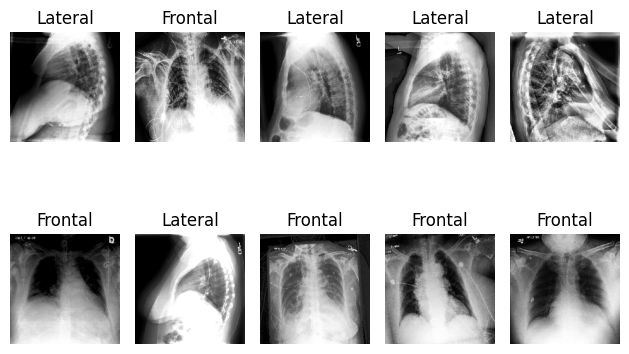

In [ ]:
import matplotlib.pyplot as plt

plt.figure() 
imagenlabel0 = 0 # Inicializar contador para label=0
imagenlabel1 = 0 # Inicializar contador para label=1
posicionFigure = 0 # Contador para la posición en la figura de cada imagen.

# Adapto para que el método imshow() muestre imágenes en escala de grises (Por defecto muestra RGB)
for images, labels in train_dataset:
    for i in range(len(labels)):
        if imagenlabel0 == 5 and imagenlabel1 == 5:
            break
        elif labels[i] == 0 and imagenlabel0 <= 4:
            axes = plt.subplot(2, 5, posicionFigure+1)
            dim = images[i, :, :, 0]
            plt.imshow(dim, cmap='gray')
            posicionFigure = posicionFigure + 1
            imagenlabel0 = imagenlabel0 + 1
            plt.title('Frontal')
            plt.axis("off")
        elif labels[i] == 1 and imagenlabel1 <= 4:
            axes = plt.subplot(2, 5, posicionFigure+1)
            dim = images[i, :, :, 0]
            plt.imshow(dim, cmap='gray')
            posicionFigure = posicionFigure + 1
            imagenlabel1 = imagenlabel1 + 1
            plt.title('Lateral')
            plt.axis("off")
        else:
            pass
    if imagenlabel0 == 5 and imagenlabel1 == 5:
        break

plt.tight_layout()
plt.show()


### Entrenamiento del modelo C-Plus (Modelo C con aumento de datos)



In [ ]:
from math import ceil

model=get_model() 
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Creamos directorio donde almacenar resultados (models), las distintas redes se guardaran aqui.
# Cada una se guarda en su priopio directorio con nombre: Modelo{1....6}
path_models = Path('models')
path_experiment = path_models / (f'Modelo-CPlus')
path_experiment.mkdir(exist_ok=True, parents=True)
#Generamos el callback y earlystoped.
earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="min", patience=6,
                                                  restore_best_weights=True,
                                                  verbose=0)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=path_experiment / 'xrai_frontal_lateral.h5',
monitor='val_loss',
mode='min',
save_best_only=True,
verbose=1)

train_steps = ceil(train_dataset.n/32)  #Redondeo al alza para asegurarme que todas las imagenes pasen durante el entrenamiento
validation_steps = ceil(validation_dataset.n/32) 

#Entrenamiento
history_plus=model.fit(train_dataset,
                  steps_per_epoch = train_steps,
                  epochs=20,
                  batch_size=32,
                  validation_data=val_dataset,
                  validation_steps=validation_steps,
                  callbacks=[model_checkpoint_callback,earlystopping],
                  verbose=0)
    
#Guardado del archivo history.npy con las metricas de cada modelo
np.save(path_experiment / 'history.npy', history_plus.history)


Epoch 1: val_loss improved from inf to 0.69567, saving model to models/Modelo-CPlus/xrai_frontal_lateral.h5

Epoch 2: val_loss improved from 0.69567 to 0.68252, saving model to models/Modelo-CPlus/xrai_frontal_lateral.h5

Epoch 3: val_loss improved from 0.68252 to 0.53577, saving model to models/Modelo-CPlus/xrai_frontal_lateral.h5

Epoch 4: val_loss did not improve from 0.53577

Epoch 5: val_loss improved from 0.53577 to 0.31820, saving model to models/Modelo-CPlus/xrai_frontal_lateral.h5

Epoch 6: val_loss did not improve from 0.31820

Epoch 7: val_loss improved from 0.31820 to 0.16373, saving model to models/Modelo-CPlus/xrai_frontal_lateral.h5

Epoch 8: val_loss did not improve from 0.16373

Epoch 9: val_loss did not improve from 0.16373

Epoch 10: val_loss improved from 0.16373 to 0.14175, saving model to models/Modelo-CPlus/xrai_frontal_lateral.h5

Epoch 11: val_loss did not improve from 0.14175

Epoch 12: val_loss did not improve from 0.14175

Epoch 13: val_loss improved from 0

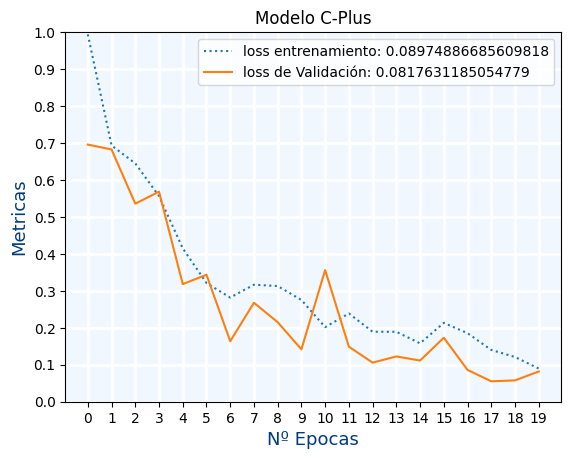

In [ ]:
figure=plt.figure()
axes = figure.add_subplot()

axes.plot(history_plus.history['loss'],linestyle="dotted",label="loss entrenamiento: " + str(history_plus.history['loss'][-1]))
axes.plot(history_plus.history['val_loss'],label="loss de Validación: " + str(history_plus.history['val_loss'][-1]))

axes.set_xlabel('Nº Epocas', fontsize=13, color="#003B80")
axes.xaxis.set_major_locator(ticker.MaxNLocator(nbins=25,integer=True))

axes.set_ylabel('Metricas', fontsize=13, color="#003B80")
axes.set_ylim(ymin=0,ymax=1)
axes.yaxis.set_major_locator(ticker.MultipleLocator(0.1)) 

axes.set_title('Modelo C-Plus')
axes.set_facecolor("#F0F7FF")
axes.grid(visible=True, which='major', axis='both', color="#FFFFFF", linewidth=2)

plt.legend()

## Ejercicio 8: Comparacion de modelos C-Plus y MobileNetV2 (Mejor modelo del ejercicio 6)

In [ ]:
# Cargar el modelo entrenado C-Plus
model = tf.keras.models.load_model('/content/models/Modelo-CPlus/xrai_frontal_lateral.h5')

# Obtener las etiquetas predichas (y_pred_cplus)
y_pred_cplus = []
stop_flag = False  # Variable de control para detener el bucle
batches_processed = 0  # Variable auxiliar para contar los lotes procesados

for images, _ in val_dataset:
    predictions = model.predict(images)
    labels = (predictions >= 0.5).astype(int)
    y_pred_cplus.extend(labels.flatten())
    batches_processed += 1

    if stop_flag:
        break  # Detener el bucle si se establece la variable de control

    # Verificar si se han procesado todos los lotes del generador
    if batches_processed == (len(val_dataset)-1):
        stop_flag = True

y_pred_cplus = np.array(y_pred_cplus)




1/1 [==============================] - 0s 24ms/step


In [ ]:
metricas_Cplus = calcular_metricas(y_true, y_pred_cplus)

# Crear el DataFrame con las métricas
data = {'Métrica': ['VP', 'VN', 'FP', 'FN', 'Accuracy', 'Precision', 'Recall', 'NPV', 'Specificity', 'F1', 'MCC', 'AUC'],
        'Modelo C Plus': metricas_Cplus,
        'Modelo MobileNetV2': metricas_mobilenetV2}

df = pd.DataFrame(data)

# Formatear las métricas VP, VN, FP, FN sin decimales
df[['Modelo C Plus', 'Modelo MobileNetV2']] = df[['Modelo C Plus', 'Modelo MobileNetV2']].applymap(lambda x: f'{x:.0f}' if isinstance(x, float) and x.is_integer() else x)

# Calcular la mejor métrica y agregarla al DataFrame
df['Mejor Modelo'] = df[['Modelo C Plus', 'Modelo MobileNetV2']].apply(lambda row: 'C-Plus' if float(row['Modelo C Plus']) > float(row['Modelo MobileNetV2']) else 'MobileNetV2', axis=1)
df.head(50)

,Métrica,Modelo C Plus,Modelo MobileNetV2,Mejor Modelo
0,VP,88,100,MobileNetV2
1,VN,90,98,MobileNetV2
2,FP,10,2,C-Plus
3,FN,12,0,C-Plus
4,Accuracy,0.89,0.99,MobileNetV2
5,Precision,0.897959,0.980392,MobileNetV2
6,Recall,0.88,1,MobileNetV2
7,NPV,0.882353,1,MobileNetV2
8,Specificity,0.9,0.98,MobileNetV2
9,F1,0.888889,0.990099,MobileNetV2


Observando los dos modelos, se puede concluir que el Modelo MobileNetV2 sobresale sobre el Modelo C-Plus. Aunque el Modelo C-Plus presenta una pérdida en validación ligeramente más alta que el Modelo MobileNetV2, todas las demás métricas indican claramente la superioridad del Modelo MobileNetV2. Con una mayor precisión, recall, F1-score y MCC, el Modelo MobileNetV2 demuestra su capacidad para realizar predicciones más precisas y confiables. Además, el Modelo MobileNetV2 muestra una mayor tasa de verdaderos positivos, una especificidad más alta y un rendimiento general superior en todas las métricas evaluadas. Por lo tanto, se puede afirmar que el Modelo MobileNetV2 es el mejor modelo de los distintos que se han comparado.

## Ejercicio 9: Predicción con mi mejor modelo

Cojo el que es mi modelo definitivo, el modelo de MobilNetV2

In [ ]:
model = tf.keras.models.load_model('/content/models/ModeloMobileNetV2/xrai_frontal_lateral_mobilenet.h5')

### Predicción con la imagen 1:

In [ ]:
download = drive.CreateFile({'id': '1ZA4f7_3t6i0-EBCmg9wQOtf3h5gMG8wy'})
download.GetContentFile('frontal.png')

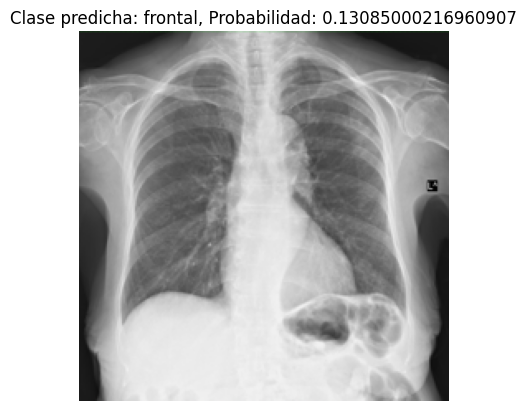

In [ ]:
from PIL import Image

# Cargar la imagen
image_path = "frontal.png" 
image = Image.open(image_path)

# Como el modelo MobileNetV2 tiene capa de preproceso integrada solo adapto el tamaño de la imagen y paso a RGB
image = image.resize((224, 224)) 
image = image.convert("RGB")

# Predicción
prediction = model.predict(np.expand_dims(image, axis=0),verbose=False) #Añado la "dimension del lote", en este caso 1.
probability = prediction[0][0]

# Etiqueta
if probability < 0.5:
    tipo_clase = "frontal"
else:
    tipo_clase = "lateral"

# Mostrar el resultado
plt.imshow(image,cmap='gray')
plt.title(f"Clase predicha: {tipo_clase}, Probabilidad: {probability}")
plt.axis('off')
plt.show()

### Predicción con la imagen 2:

In [ ]:
download = drive.CreateFile({'id': '1mcI0chvx2qplMcPALm3iqVLCfwxXgxav'})
download.GetContentFile('lateral.png')

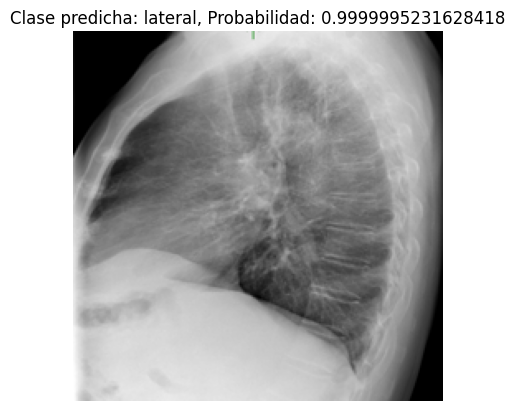

In [ ]:
# Cargar la imagen
image_path = "lateral.png" 
image = Image.open(image_path)

# Como el modelo MobileNetV2 tiene capa de preproceso integrada solo adapto el tamaño de la imagen y paso a RGB
image = image.resize((224, 224)) 
image = image.convert("RGB")

# Predicción
prediction = model.predict(np.expand_dims(image, axis=0),verbose=False)
probability = prediction[0][0]

#Etiqueta
if probability < 0.5:
    tipo_clase = "frontal"
else:
    tipo_clase = "lateral"

# Muestra la imagen junto con el resultado
plt.imshow(image,cmap='gray')
plt.title(f"Clase predicha: {tipo_clase}, Probabilidad: {probability}")
plt.axis('off')
plt.show()

## Conclusiones y problemas encontrados.

### Problemas encontrados.

*   Y_true y Y_pred del Dataset de Validacion:  
El dataset de validación creado con image_dataset_from_directory() es un objeto de Keras, que ha cada llamada del objeto, este cambia el orden en que muestra las imagenes, imposibilitando sacar la y_true en concordancia (Coincidiendo los registros) con la y_pred.   
 **La solución** adoptada pasa por quitarle la variabilidad al dataset de validacion (solo a la validacion) de forma que no cambie el orden en cada llamada al mismo.

*   Dataset validación con aumento de datos:
La funcion flow_from_directory de Keras no esta pensada para asignar el 100% de un directorio al dataset de validación.  
  **La solución** adoptada pasa por eliminar el split (split a 0) del generador de keras y asigandole la etiqueta 'training' al crear el dataset, de esta forma le asigna el 100% de la imagenes a este dataset.

* Modelo MobilenetV2:
Originalmente el tamaño de imagen para el que se descarga el modelo es de (256,256), al entrenar me doy cuenta que los resultados, incluidas las metricas no son los esperados.  
  **La solución** adopatada pasa por cambiar el tamaño de imagen a uno predefinido en el mismo modelo por keras, en este caso (224,224) y añado una capa densa mas en la clasificacion. Entrenando con estos cambios las metricas mejoran notablemente.

* Train_steps() y Validation_steps():  
Despues de la creación de los dataset con aumento de datos con flow_from_directory(), para el entrenamiento hay que especificar el numero de lotes en cada dataset (cada numero de lote sera un step), pero la division de mis imagenes con mi tamaño de lote no es exacta.  
  **La solución** adoptada pasa por redondear al alza con la funcion ceil() de math. De esta forma me aseguro que todas mis imagenes se utilicen en el entrenamiento. Mis datasets tienen 600 y 200 imagenes y mi tamaño de lote es 32, por lo que dan 18,75 y 6,25 lotes respectivamente. Con ceil() el numero de steps sera 19 y 7, de tal forma pasan todos los lotes y por ende todas las imagenes.

### Conclusiones del proyecto.

Después de analizar y comparar todos los modelos de mi proyecto, he llegado a varias conclusiones que considero importantes.   

Inicialmente, consideré que el modelo MobileNetV2, al ser una arquitectura preentrenada, superaría al modelo C-Plus que fue creado manualmente. Sin embargo, durante las primeras pruebas, el modelo C-Plus mostró un rendimiento ligeramente superior al de MobileNetV2, lo que me llevó a replantear mis expectativas.

Dado que las métricas obtenidas no cumplían con lo esperado, decidí realizar una serie de ajustes en el modelo MobileNetV2. En primer lugar, descargué el modelo con una configuración de tamaño de imagen predefinido por Keras, en este caso, 224x224 (Al principio se descargaba con un tamaño de imagen de 256x256). Además, agregué una capa densa adicional en la etapa de clasificación. Estas modificaciones resultaron en un notable aumento en las métricas del modelo MobileNetV2, superando así al modelo C-Plus.

Sin embargo, a lo largo del proyecto, me doy cuenta de que el equilibrio entre un buen modelo y unos buenos datos es fundamental. Aunque el modelo MobileNetV2 se destacó como el mejor en este momento, también tengo la seguridad de que con ajustes adicionales y un entrenamiento adecuado, el modelo C-Plus podría competir en igualdad de condiciones. Esto me lleva a concluir que la calidad de los datos y el proceso de entrenamiento son tan importantes como la elección del modelo en sí.

En resumen, creo que no existe una diferencia significativa entre el modelo C-Plus y el MobileNetV2 en términos de su validez y eficacia (Desde el punto de vista de este problema concreto). Estoy convencido que el modelo C-plus podría alcanzar un rendimiento comparable al del MobileNetV2. Esto reafirma mi creencia de que encontrar un equilibrio entre un buen modelo y datos sólidos es crucial en el proceso de desarrollo de modelos de inteligencia aritificial.